# Project 6: Time Series Analysis & Forecasting 📈

**Project Objective:** To build a time series model to forecast the number of airline passengers for future months. This project provides a comprehensive, step-by-step guide to time series analysis, from data decomposition and stationarity testing to building and evaluating ARIMA and SARIMA models.

### Core Concepts We'll Cover:
1.  **Time Series Fundamentals:** Understanding the components of a time series (Trend, Seasonality, Residuals).
2.  **Stationarity:** Learning what stationarity is, why it's crucial for many models, and how to test for it (Augmented Dickey-Fuller test).
3.  **Data Transformation:** Applying techniques like differencing and log transforms to make a series stationary.
4.  **Model Identification:** Using Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots to determine model parameters.
5.  **ARIMA Modeling:** Building a baseline ARIMA model for forecasting.
6.  **SARIMA Modeling:** Extending ARIMA to build a powerful SARIMA model that explicitly handles seasonality.
7.  **Forecasting & Evaluation:** Making predictions and evaluating model performance.

### Step 1: Setup - Importing Libraries and Loading Data

In [1]:
pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set plot style and size
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"

fatal: destination path '21-Days-21-Projects-Dataset' already exists and is not an empty directory.


In [4]:
df = pd.read_csv('/content/21-Days-21-Projects-Dataset/Datasets/airline_passenger_timeseries.csv')
df.head(5)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


### Step 2: Exploratory Data Analysis & Decomposition

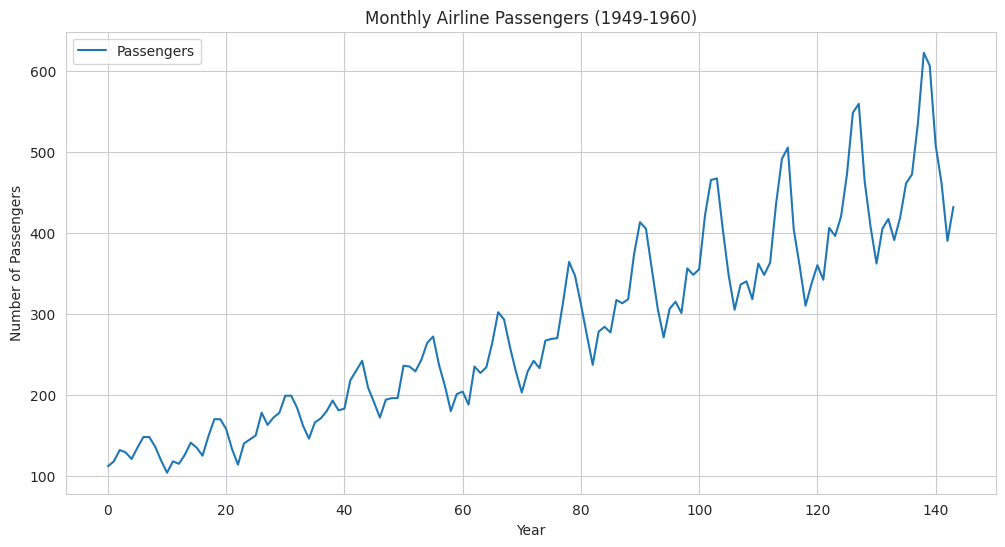

In [5]:
df.plot()
plt.title('Monthly Airline Passengers (1949-1960)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

**Initial Observation:** The plot clearly shows two strong patterns:
1.  **Upward Trend:** The number of passengers is increasing over time.
2.  **Seasonality:** There is a clear, repeating annual pattern (peaks and troughs within each year).
3.  **Increasing Variance:** The seasonal fluctuations appear to be getting larger over time.

sm.tsa.seasonal_decompose: This function from the statsmodels library performs the decomposition.'

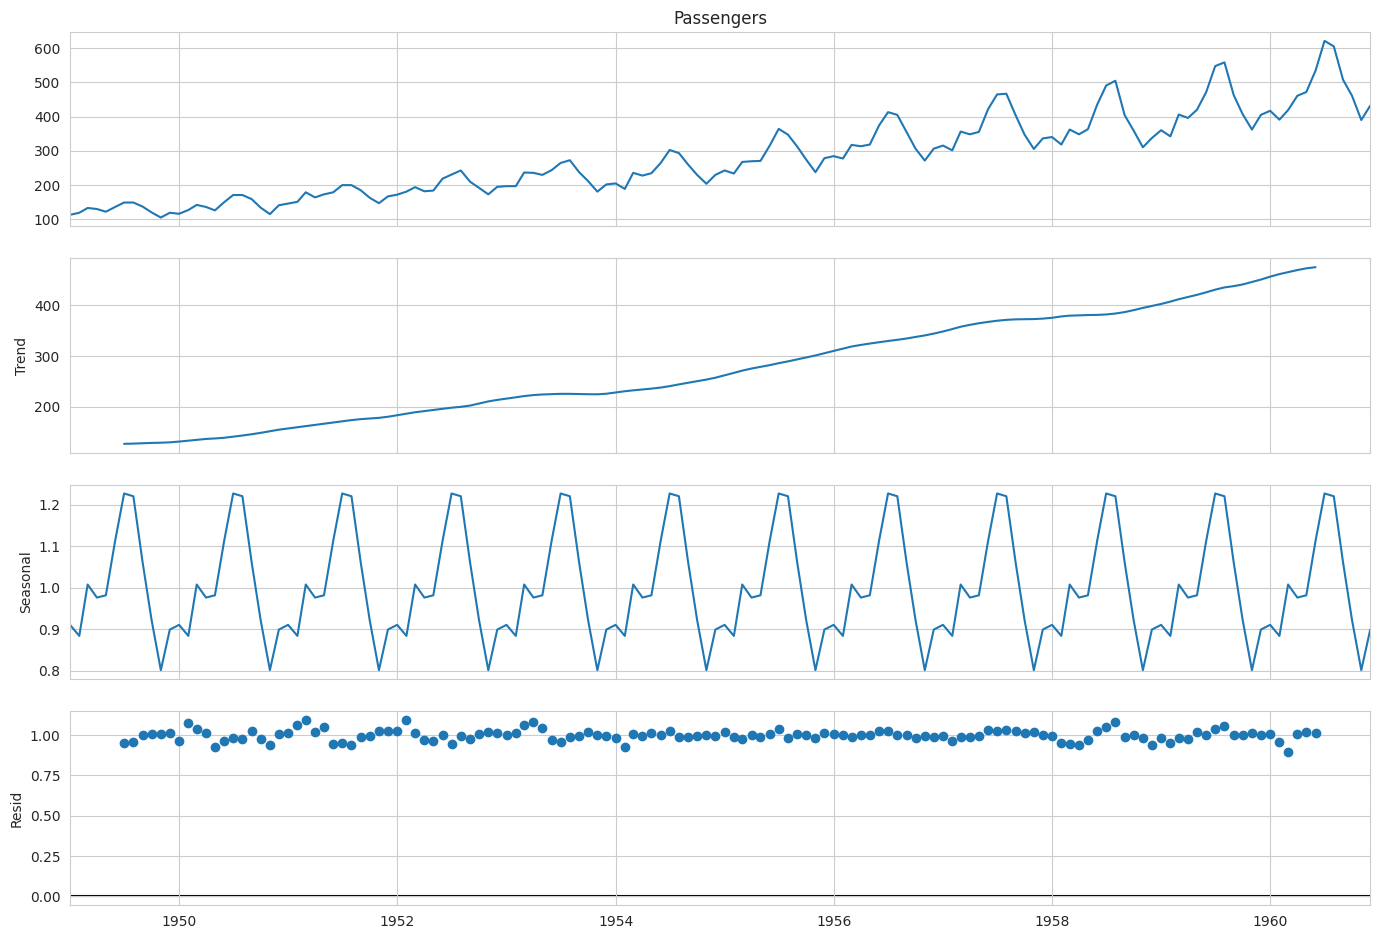

In [6]:
# Convert 'Month' to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Decompose the time series to visualize its components
decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

### Step 3: Stationarity Testing
Before we can build a model like ARIMA, the time series needs to be **stationary**.
- A time series is said to be stationary if its statistical properties—specifically the mean, variance, and autocorrelation—are constant over time.
- easier to model and forecast
- If a series is stationary, its past behavior is a good predictor of its future behavior.

Our data is clearly non-stationary because its mean (the trend is increasing) and variance (the seasonal swings are growing) are not constant.

We can check if the data is stationary by:

- Visualization
- **Statistical testing (ADF testing:** checking if p-value is less than 0.05)
  - **Null Hypothesis (
):** italicised text The series is non-stationary.
  - **Alternative Hypothesis (
):** The series is stationary.
  - We want to **reject the null hypothesis**. To do this, we need the **p-value** from the test to be less than a significance level (e.g., 0.05).

In [7]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


### Step 4: Making the Series Stationary
We'll use two common techniques: **log transformation** to stabilize the variance and **differencing** to remove the trend.

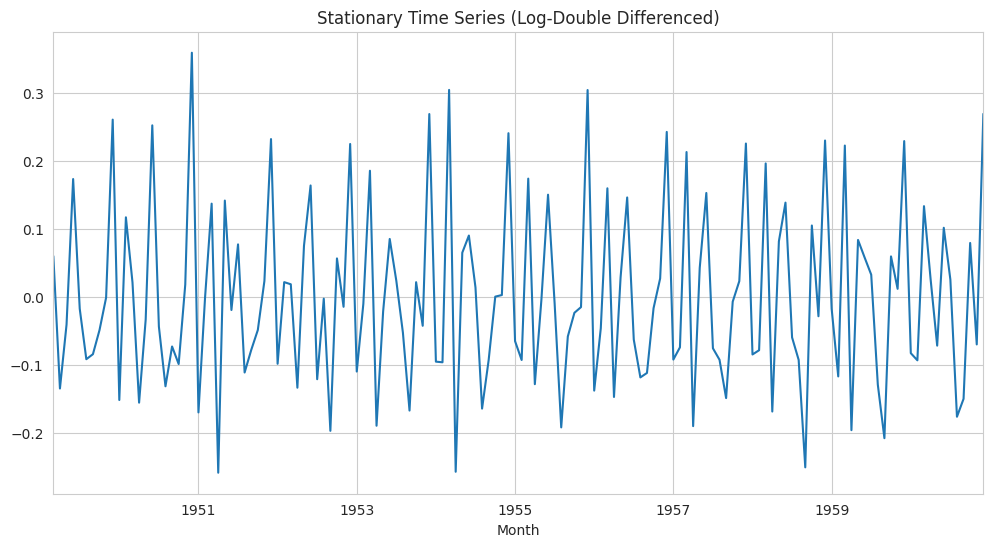

Testing stationarity after log transformation and double differencing:
Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64

Result: The time series is stationary (p-value < 0.05).


In [8]:
# 1. Apply log transformation to stabilize the variance
df_log = np.log(df['Passengers'])

# 2. Apply differencing to remove the trend
df_diff = df_log.diff().dropna()

# Apply a second level of differencing
df_diff2 = df_diff.diff().dropna()

# Plot the stationary series
df_diff2.plot()
plt.title('Stationary Time Series (Log-Double Differenced)')
plt.show()

# Retest for stationarity
print("Testing stationarity after log transformation and double differencing:")
test_stationarity(df_diff2)

# Check if p-value is less than 0.05
dftest = adfuller(df_diff2, autolag='AIC')
if dftest[1] < 0.05:
    print("\nResult: The time series is stationary (p-value < 0.05).")
else:
    print("\nResult: The time series is not yet stationary (p-value >= 0.05). Further differencing might be needed.")

**Result:** The new p-value is `0.02`, which is less than 0.05. We can now **reject the null hypothesis**. Our series is stationary and ready for modeling!

### Step 5: Model Identification with ACF and PACF Plots

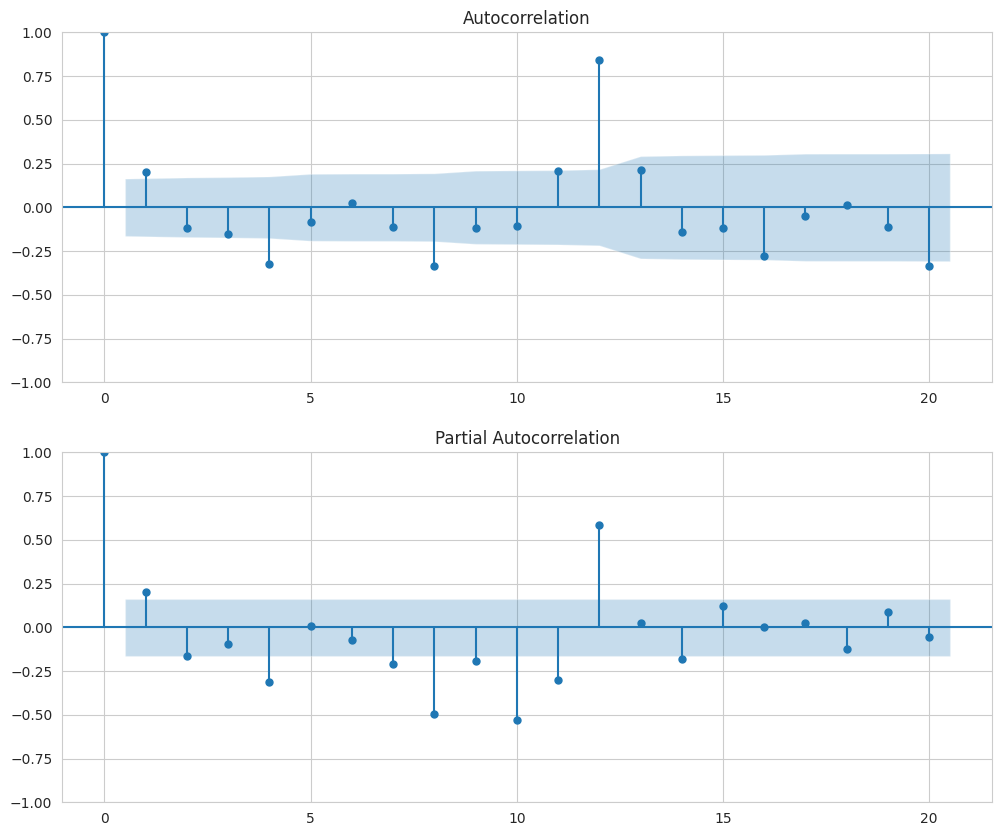

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df_diff, ax=ax1, lags=20)
plot_pacf(df_diff, ax=ax2, lags=20)
plt.show()

**Interpretation:**
- **PACF Plot:** Cuts off sharply after lag 1. This suggests `p=1`.
- **ACF Plot:** Also seems to cut off after lag 1. This suggests `q=1`.
Based on this, a good starting point for our model is **ARIMA(1, 1, 1)**.

### Step 6: Building the ARIMA Model

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


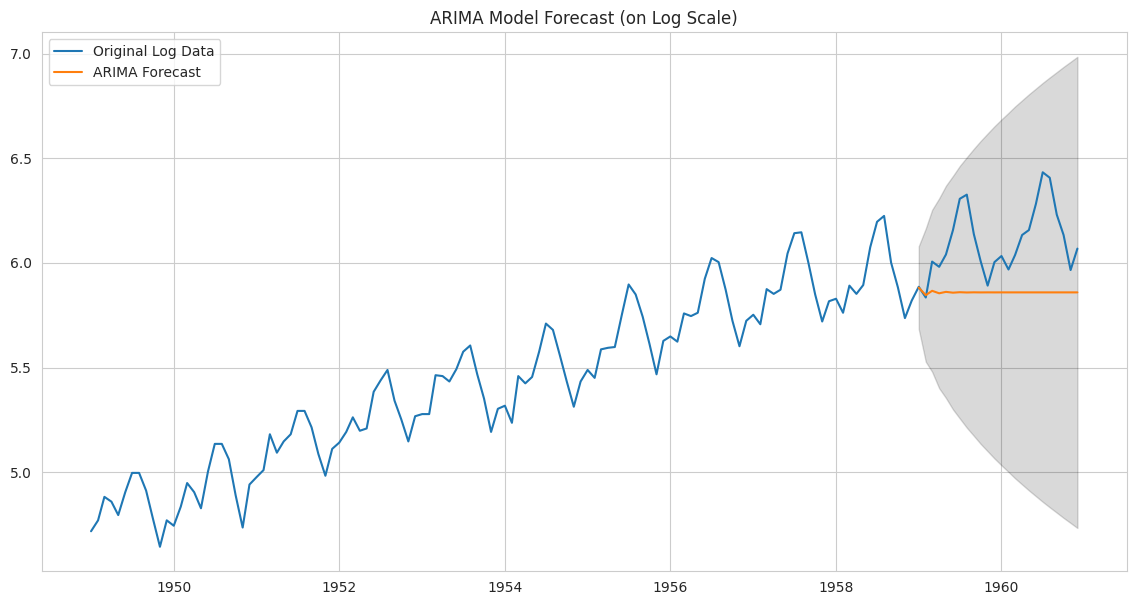

In [10]:
# Split the original log data into training and test sets
train_data = df_log[:'1958']
test_data = df_log['1959':]

# Build ARIMA model on the log-transformed training data
# The order (p, d, q) is based on the analysis of the differenced data (df_diff).
# We use d=1 here as we determined one level of differencing was needed.
model = ARIMA(train_data, order=(1, 1, 1), freq='MS')
arima_result = model.fit()

# Get forecast on the log scale
forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='ARIMA Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast (on Log Scale)')
plt.legend()
plt.show()

**ARIMA Result:** The model captures the overall trend but completely misses the seasonal pattern. This is a classic limitation of a non-seasonal ARIMA model on seasonal data.

### Step 7: Building a SARIMA Model for Seasonality

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


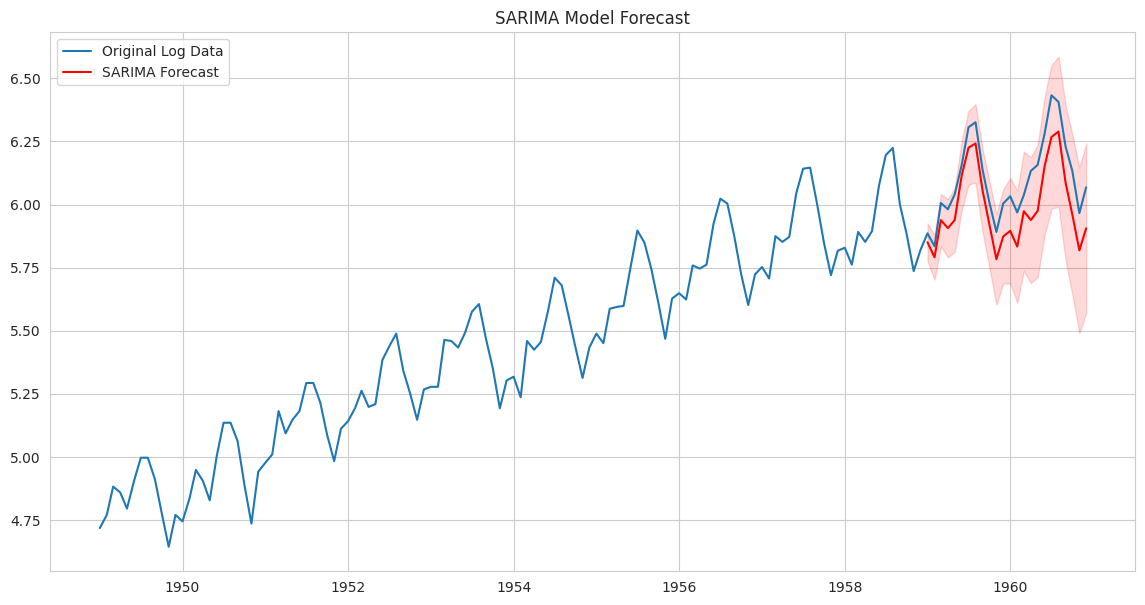

In [11]:
# Build SARIMA model
# We can find the optimal P, D, Q through a grid search, but common values are 1.
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS') # Explicitly set frequency to suppress warnings
sarima_result = sarima_model.fit()

# Get forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='r', alpha=.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

**SARIMA Result:** This is a massive improvement! The SARIMA model correctly captures both the upward trend and the seasonal peaks and troughs.

### Step 8: Final Evaluation

SARIMA Model RMSE: 53.04


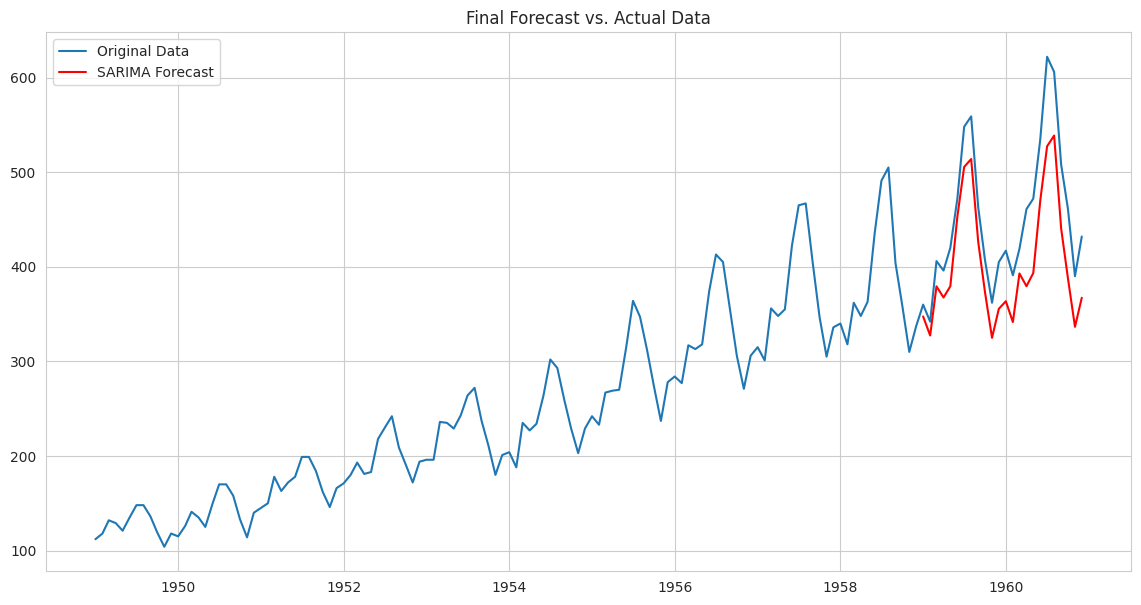

In [12]:
# Reverse the log transformation to get actual passenger numbers
original_test_data = np.exp(test_data)
sarima_predictions = np.exp(sarima_forecast.predicted_mean)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(original_test_data, sarima_predictions))
print(f"SARIMA Model RMSE: {rmse:.2f}")

# Plot final results
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data')
plt.plot(sarima_predictions, label='SARIMA Forecast', color='red')
plt.title('Final Forecast vs. Actual Data')
plt.legend()
plt.show()

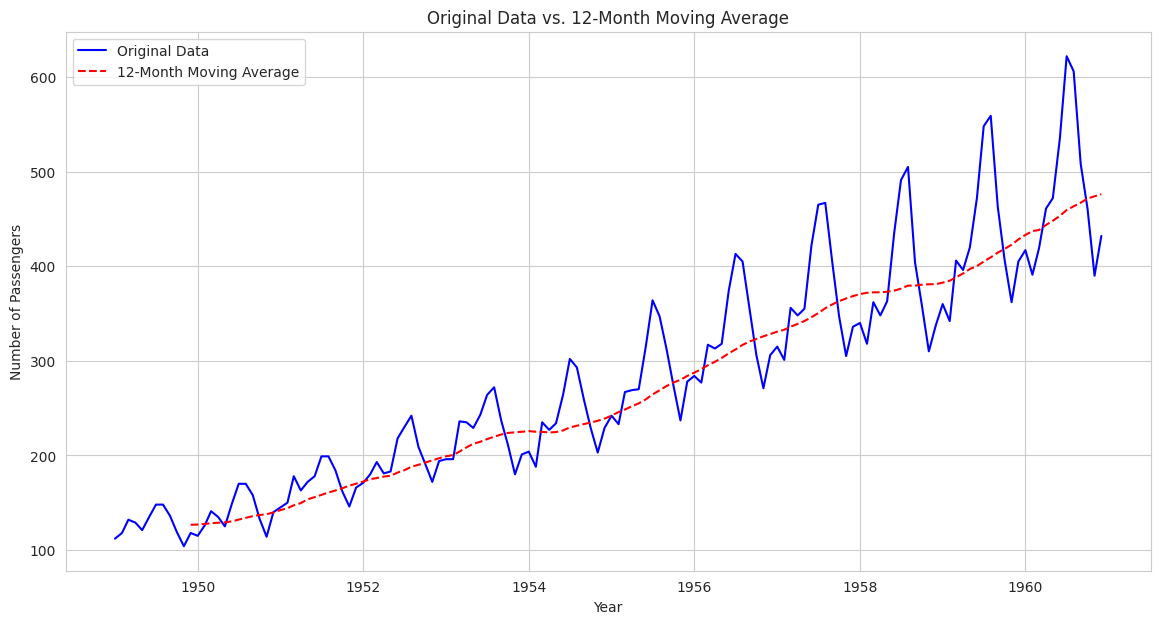

In [13]:
# Calculate the rolling mean with a window size of 12
df['MovingAverage'] = df['Passengers'].rolling(window=12).mean()

# Plot the original data and the moving average
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data', color='blue')
plt.plot(df['MovingAverage'], label='12-Month Moving Average', color='red', linestyle='--')
plt.title('Original Data vs. 12-Month Moving Average')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


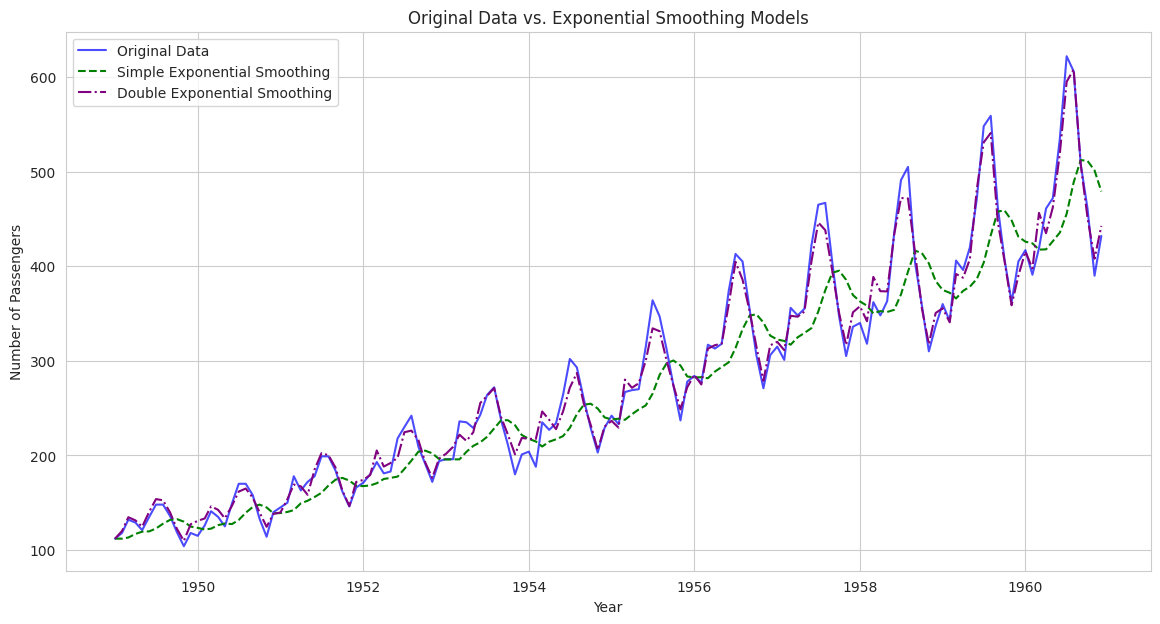

In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# 2. Fit a simple exponential smoothing model
ses_model = SimpleExpSmoothing(df['Passengers']).fit(smoothing_level=0.2, optimized=False)
df['SimpleExpSmoothing'] = ses_model.fittedvalues

# 3. Fit a double exponential smoothing model
des_model = ExponentialSmoothing(df['Passengers'], trend='add', seasonal='add', seasonal_periods=12).fit()
df['DoubleExpSmoothing'] = des_model.fittedvalues

# 4. Plot the original data and the fitted values from both models
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data', color='blue', alpha=0.7)
plt.plot(df['SimpleExpSmoothing'], label='Simple Exponential Smoothing', color='green', linestyle='--')
plt.plot(df['DoubleExpSmoothing'], label='Double Exponential Smoothing', color='purple', linestyle='-.')
plt.title('Original Data vs. Exponential Smoothing Models')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


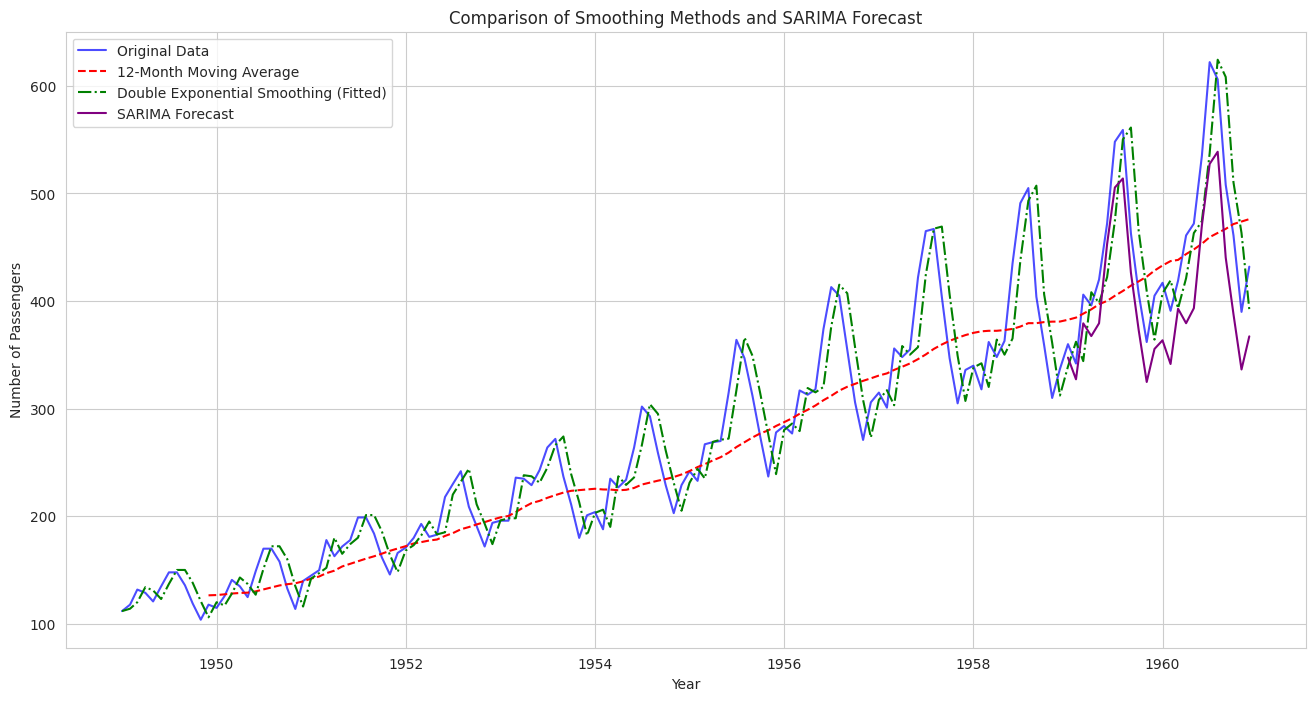

In [15]:
# Implement Double Exponential Smoothing for comparison
# We need to re-fit the DoubleExpSmoothing model as it was not saved as a variable
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Double Exponential Smoothing model on the entire data for visualization
# Assuming an additive trend based on the initial plot
double_exp_smoothing_model = ExponentialSmoothing(df['Passengers'], trend='add', seasonal=None)
double_exp_smoothing_fit = double_exp_smoothing_model.fit()
df['DoubleExpSmoothing'] = double_exp_smoothing_fit.fittedvalues

# Generate a plot comparing original, MA, Double ES, and SARIMA forecasts
plt.figure(figsize=(16, 8))
plt.plot(df['Passengers'], label='Original Data', color='blue', alpha=0.7)
plt.plot(df['MovingAverage'], label='12-Month Moving Average', color='red', linestyle='--')
plt.plot(df['DoubleExpSmoothing'], label='Double Exponential Smoothing (Fitted)', color='green', linestyle='-.')
# Plot SARIMA forecast (need to re-run SARIMA forecast as the variable is not available)
# Re-split data and fit SARIMA model to get forecast
train_data = df_log[:'1958']
test_data = df_log['1959':]
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS')
sarima_result = sarima_model.fit()
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_predictions_plot = np.exp(sarima_forecast.predicted_mean)


plt.plot(sarima_predictions_plot, label='SARIMA Forecast', color='purple')

plt.title('Comparison of Smoothing Methods and SARIMA Forecast')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

#### Visual Comparison Summary

Looking at the plot, we can observe the following:

- **Moving Average:** Successfully smooths out the short-term noise and clearly shows the underlying upward trend. However, it lags behind the actual data and completely misses the seasonal fluctuations. It is not suitable for forecasting seasonal data.

- **Double Exponential Smoothing:** Does a better job than the simple moving average in following the trend. It reacts more quickly to changes but still does not capture the strong seasonality present in the data. It's an improvement for trending data but not for data with significant seasonality.

- **SARIMA Forecast:** Clearly outperforms both moving average and double exponential smoothing for this dataset. It effectively captures both the long-term upward trend and the distinct annual seasonal pattern, aligning closely with the actual data in the forecast period. This demonstrates the power of SARIMA models when dealing with time series that have both trend and seasonality.

## Submission Criteria

* Make the p value less than 0.05 and then build the ARIMA model and share the notebook with me

# Submission

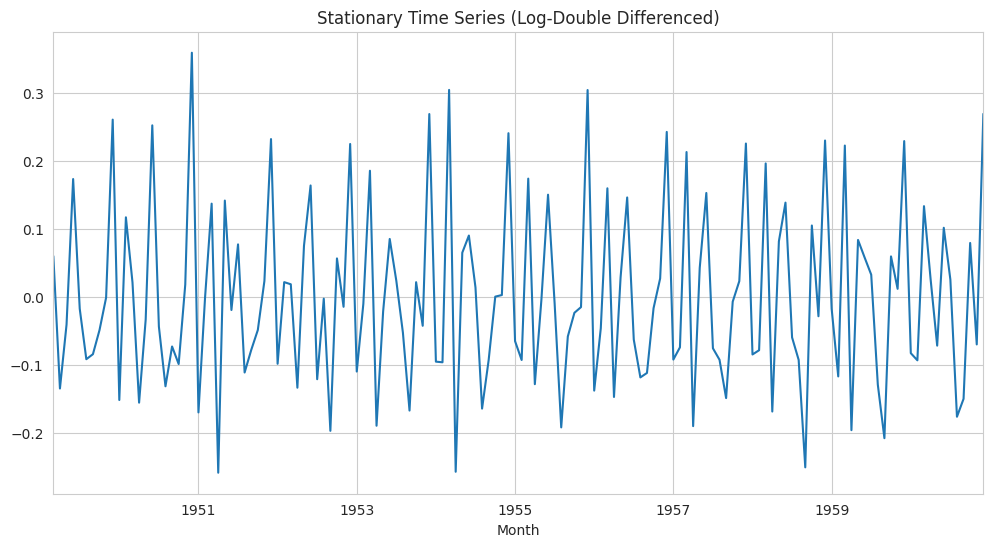

Testing stationarity after log transformation and double differencing:
Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64

Result: The time series is stationary (p-value < 0.05).


In [16]:
# 1. Apply log transformation to stabilize the variance
df_log = np.log(df['Passengers'])

# 2. Apply differencing to remove the trend
df_diff = df_log.diff().dropna()

# Apply a second level of differencing
df_diff2 = df_diff.diff().dropna()

# Plot the stationary series
df_diff2.plot()
plt.title('Stationary Time Series (Log-Double Differenced)')
plt.show()

# Retest for stationarity
print("Testing stationarity after log transformation and double differencing:")
test_stationarity(df_diff2)

# Check if p-value is less than 0.05
dftest = adfuller(df_diff2, autolag='AIC')
if dftest[1] < 0.05:
    print("\nResult: The time series is stationary (p-value < 0.05).")
else:
    print("\nResult: The time series is not yet stationary (p-value >= 0.05). Further differencing might be needed.")

#### p-value = 7.419305e-13 < 0.05
Applied second level of differencing to the log-transformed data.